In [1]:
from jqdata import *
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
start_date = get_trade_days(end_date='2006-2-1',count=17)[0]
end_date = get_trade_days(end_date='2006-2-1',count=17)[-2]

In [18]:
def del_nul(data):
    for name,num in dict(data.apply(lambda x:sum(x.isnull()))).items():
        if num!=0:
            data = data.drop(name,axis=1)
            print(name+'有'+str(num)+'条缺失值！已删除该列！')
    return data

In [19]:
def get_all_sw_data(start_date,end_date):
    '''
    start_date：起始日期
    end_date：截止日期
    return：一个日度收盘价数据表、一个日度开盘价数据表，表头是所有的编号
    '''
    code_list = list(get_industries('sw_l1',date=end_date).index)
    data_open = pd.DataFrame()
    data_close = pd.DataFrame()
    for code in code_list:     
        q1 = query(
            finance.SW1_DAILY_PRICE.name,
            finance.SW1_DAILY_PRICE.open,
            finance.SW1_DAILY_PRICE.date
            ).filter(
            finance.SW1_DAILY_PRICE.code==code,
            finance.SW1_DAILY_PRICE.date>=start_date,
            finance.SW1_DAILY_PRICE.date<=end_date
            )
        q2 = query(
            finance.SW1_DAILY_PRICE.name,
            finance.SW1_DAILY_PRICE.close,
            finance.SW1_DAILY_PRICE.date
            ).filter(
            finance.SW1_DAILY_PRICE.code==code,
            finance.SW1_DAILY_PRICE.date>=start_date,
            finance.SW1_DAILY_PRICE.date<=end_date
            )
        code_data_open = finance.run_query(q1)
        code_data_close = finance.run_query(q2)
        data_open[code] = code_data_open.open
        data_close[code] = code_data_close.close
    data_open.index = code_data_open.date
    data_close.index = code_data_close.date
    #去除有空值的列，因为有些指数是2021年才有的
    data_open = del_nul(data_open)
    data_close = del_nul(data_close)
    return data_open,data_close

In [24]:
data_open,data_close = get_all_sw_data(start_date,end_date)

In [26]:
data_open.head()

,801020,801110,801160,801060,801010,801120,801050,801170,801090,801130,801180,801220,801200,801230,801140,801080,801030,801100,801190,801210,801070,801150,801040
date,,,,,,,,,,,,,,,,,,,,,,,
2005-12-30,1347.34,421.31,802.02,610.43,421.18,919.03,758.07,1067.68,685.36,557.87,699.15,612.27,753.38,442.66,554.49,539.77,789.68,450.74,707.70,841.43,703.12,686.22,1158.07
2006-01-04,1329.97,414.90,790.09,603.91,416.83,903.33,749.00,1049.97,678.04,552.83,690.85,608.12,745.51,436.47,549.10,537.08,784.88,450.96,723.78,838.62,697.65,678.13,1145.18
2006-01-05,1346.61,426.47,802.44,611.53,421.49,909.70,779.57,1061.27,687.55,559.19,709.31,618.73,752.47,444.84,556.56,546.75,796.12,461.38,748.85,845.95,716.03,685.56,1161.01
2006-01-06,1350.87,433.75,813.06,618.75,423.08,921.32,793.18,1096.35,700.25,566.17,724.88,632.20,755.88,451.67,565.53,554.84,802.84,468.39,753.50,865.08,726.20,696.20,1185.65
2006-01-09,1358.32,438.06,823.81,622.61,424.48,931.61,799.21,1113.53,703.66,570.86,726.99,639.29,760.50,457.60,572.38,559.59,813.94,469.34,762.81,868.33,733.19,702.43,1189.24


In [27]:
def ret(data_open,data_close):
    '''
    data_open：开盘价日度数据，index为datetime
    data_close：收盘价日读数据，index为datetime
    return：日内涨跌幅因子M0和隔夜涨跌幅因子M1
    '''
    ret_in = pd.DataFrame()
    ret_over = pd.DataFrame()
    for name in list(data_open.columns):
        #这个列表用于储存单只指数的每天开盘与收盘价
        name_open_close = pd.DataFrame()
        name_open_close['open'] = data_open[name]
        name_open_close['close'] = data_close[name]
        name_open_close.index = data_open.index
        #日内收益率为今收/今开-1
        name_open_close['ret_in'] = name_open_close['close']/name_open_close['open']-1
        #隔夜收益率为今开/昨收-1
        name_open_close['ret_over'] = name_open_close['open']/name_open_close['close'].shift(1)-1
        ret_in[name] = name_open_close['ret_in']
        ret_over[name] = name_open_close['ret_over']
    #由于隔夜收益率计算产生空值，方便起见我们直接删去第一行
    ret_in = ret_in.iloc[1:,:]
    ret_over = ret_over.dropna()
    #前十五日内收益率加总
    m0 = ret_in.rolling(15).sum()
    #前十五日隔夜收益率加总
    m1 = ret_over.rolling(15).sum()
    #同理删除空值所在行
    m0 = m0.dropna()
    m1 = m1.dropna()
    return m0,m1

In [28]:
m0,m1 = ret(data_open,data_close)

In [29]:
m0.head()

,801020,801110,801160,801060,801010,801120,801050,801170,801090,801130,801180,801220,801200,801230,801140,801080,801030,801100,801190,801210,801070,801150,801040
date,,,,,,,,,,,,,,,,,,,,,,,
2006-01-24,0.162322,0.084096,0.042713,0.062464,0.07228,0.084033,0.257563,0.010878,0.060744,0.105785,0.110323,0.111092,0.066741,0.139952,0.098217,0.157023,0.103122,0.098827,0.01342,0.048351,0.149433,0.064138,0.104718


In [30]:
def mgold(m0,m1):
    '''
    return：每只行业指数的打分
    '''
    score = pd.DataFrame(index=m0.T.index)
    for date in m0.T.columns:
        #m0从低到高打1~N分
        m0_sort = pd.DataFrame(m0.T[date].sort_values(ascending=True))
        m0_sort['score0'] =  range(1,len(m0_sort)+1)
        #m1从高到低打1~N分
        m1_sort = pd.DataFrame(m1.T[date].sort_values(ascending=False))
        m1_sort['score1'] =  range(1,len(m1_sort)+1)
        #根据行索引匹配
        sort = pd.concat([m0_sort,m1_sort],axis=1,join='inner')
        sort['score'] = sort['score0']+sort['score1']
        #让sort只保留score列
        sort = sort.drop([date,'score0','score1'],axis=1)
        score = pd.concat([score,sort],axis=1,join='inner')
    score = score.T
    #最后将列索引恢复成指数名，行索引恢复成日期
    score.index = m0.index
    return score

In [31]:
score = mgold(m0,m1)

In [32]:
score

,801020,801110,801160,801060,801010,801120,801050,801170,801090,801130,801180,801220,801200,801230,801140,801080,801030,801100,801190,801210,801070,801150,801040
date,,,,,,,,,,,,,,,,,,,,,,,
2006-01-24,44,17,11,10,23,21,36,3,10,37,36,38,17,31,22,44,29,16,3,21,38,14,31


In [2]:
top5 = pd.read_excel('top5.xls')
top5.date = top5.date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
top5 = top5.set_index('date')
tail5 = pd.read_excel('tail5.xls')
tail5.date = tail5.date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
tail5 = tail5.set_index('date')

In [3]:
def calc_value(data):
    '''
    data：top5或者tail5
    return：每个调仓日的净值
    '''
    value = pd.DataFrame(index=data.index)
    for (num,date) in [*enumerate(data.index)]:
        value_sum = 0
        if num==0:
            for code in data.loc[date,:]:
                #code本身带有单引号
                code = code[1:-1]
                q = query(
                    finance.SW1_DAILY_PRICE.close,
                    ).filter(
                    finance.SW1_DAILY_PRICE.code==code,
                    finance.SW1_DAILY_PRICE.date==date,
                    )
                value_sum += float(finance.run_query(q).close[0])
            initial_value = value_sum
            value.loc[date,0] = value_sum/initial_value
        else:
            for code in data.loc[date,:]:
                #code本身带有单引号
                code = code[1:-1]
                q = query(
                    finance.SW1_DAILY_PRICE.close,
                    ).filter(
                    finance.SW1_DAILY_PRICE.code==code,
                    finance.SW1_DAILY_PRICE.date==date,
                    )
                value_sum += float(finance.run_query(q).close[0])
            value.loc[date,0] = value_sum/initial_value            
    return value

In [8]:
def calc_change_pct(data):
    change_pct = pd.DataFrame(index=data.index)
    for date in data.index:
        for code in data.loc[date,:]:
            change_sum = 0
            #code本身带有单引号
            code = code[1:-1]
            q = query(
                finance.SW1_DAILY_PRICE.change_pct,
                ).filter(
                finance.SW1_DAILY_PRICE.code==code,
                finance.SW1_DAILY_PRICE.date==date,
                )
            change_sum += float(finance.run_query(q).change_pct[0])
        change_pct.loc[date,0] = change_sum/5 
    return change_pct

In [4]:
top5value = calc_value(top5)
tail5value = calc_value(tail5)

In [11]:
top5change = calc_change_pct(top5)
tail5change = calc_change_pct(tail5)

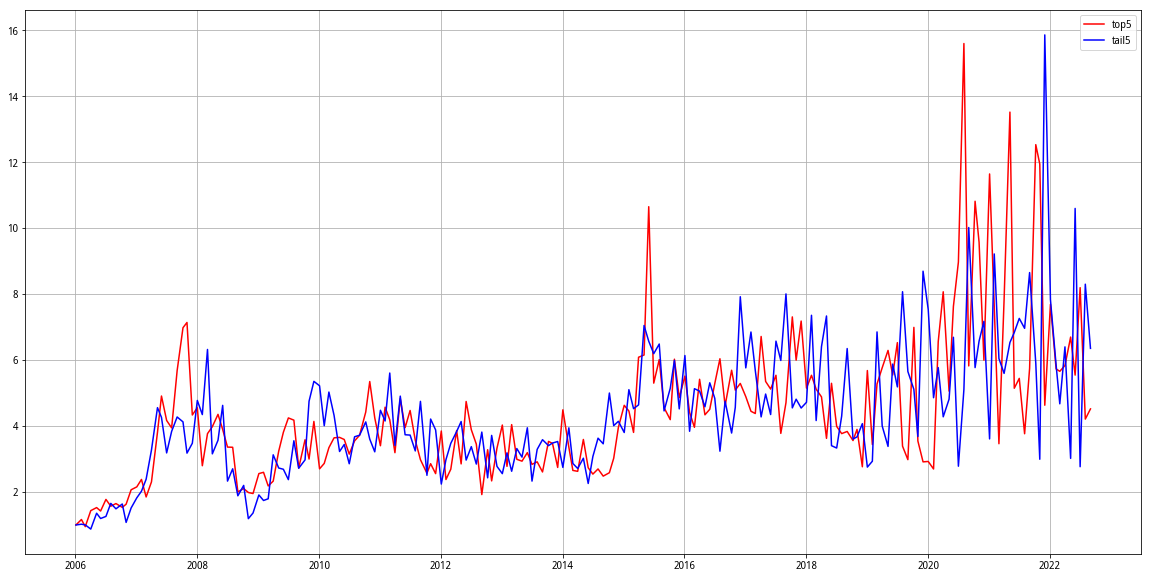

In [5]:
plt.figure(figsize=(20,10))
plt.plot(top5value,c='r',label='top5')
plt.plot(tail5value,c='b',label='tail5')
plt.legend()
plt.grid()

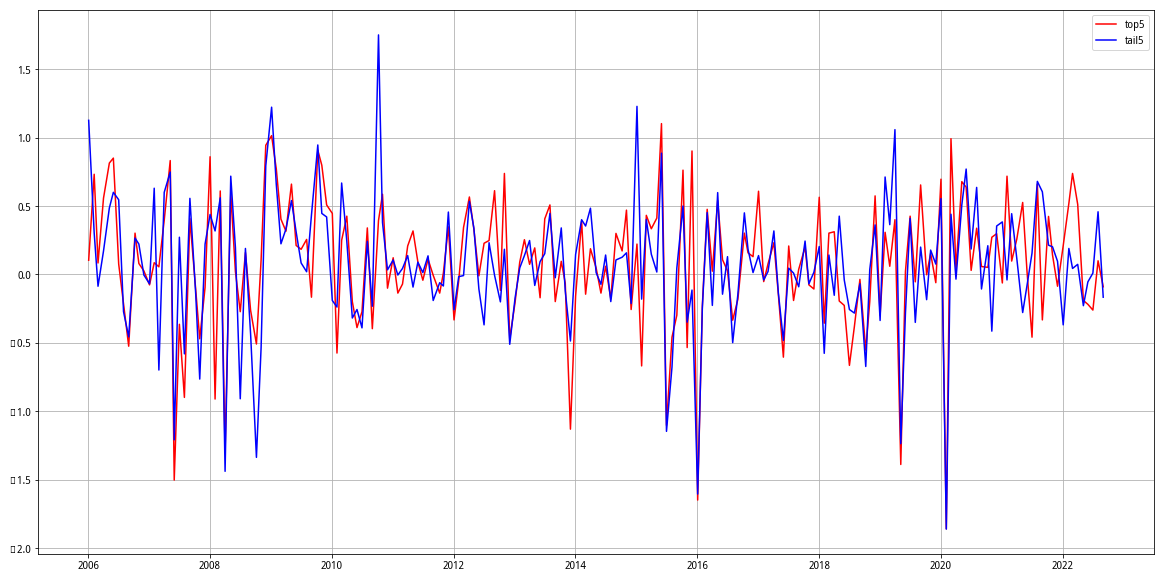

In [12]:
plt.figure(figsize=(20,10))
plt.plot(top5change,c='r',label='top5')
plt.plot(tail5change,c='b',label='tail5')
plt.legend()
plt.grid()